# Implement V subtraction method

### Apr 6, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")
import time

## Aux. functions

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [4]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

# Soft triggers distribution

In [29]:
wf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/DPulseWforms_run012559_allDepths.pkl")
softWf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/SoftTrigWforms_run012559.pkl")
wf = wf.loc[wf.theta_reco>=90]

### Add interpolated depth to df

In [30]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [31]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
wf = wf.loc[(wf.unixTime>min(wf.unixTime)) & (wf.unixTime<2.15*1E4+1.5456*1E9)]
softWf = softWf.loc[(softWf.unixTime>min(wf.unixTime)) & (softWf.unixTime<2.15*1E4+1.5456*1E9)]

interp_depth = f(wf.unixTime)
interp_depthSoft = f(softWf.unixTime)

wf["interp_depth"] = interp_depth
softWf["interp_depth"] = interp_depthSoft

In [32]:
depth_1224

,NZ_Time,depth
0,12:35,300
1,12:54,400
2,13:27,400
3,13:38,510
4,13:55,725
5,14:05,830
6,14:15,950
7,14:20,1000
8,14:29,1100
9,15:10,1100


In [10]:
def calculatePower(t, v):
    dT = t[1]-t[0]
    power = np.sum(v**2)*dT
    return power

In [11]:
wf.columns

Index(['evNum', 'ch0Wf', 'ch1Wf', 'ch2Wf', 'ch3Wf', 'ch4Wf', 'ch5Wf', 'ch6Wf',
       'ch7Wf', 'ch8Wf', 'ch9Wf', 'ch10Wf', 'ch11Wf', 'ch12Wf', 'ch13Wf',
       'ch14Wf', 'ch15Wf', 'times', 'theta_reco', 'phi_reco', 'unixTime',
       'interp_depth'],
      dtype='object')

In [12]:
# wf = wf.drop(columns=['evNum','theta_reco', 'phi_reco', 'unixTime'])
wf

,evNum,ch0Wf,ch1Wf,ch2Wf,ch3Wf,ch4Wf,ch5Wf,ch6Wf,ch7Wf,ch8Wf,...,ch11Wf,ch12Wf,ch13Wf,ch14Wf,ch15Wf,times,theta_reco,phi_reco,unixTime,interp_depth
3,84,"[59.29689144138527, 22.061614531389267, -29.15...","[-48.24317235611494, -288.74386424154903, -328...","[46.4456871773214, 4.354861831195674, -79.4323...","[-59.78185051458777, -68.88359843154657, -23.0...","[62.138970540420246, 26.21376606538485, -38.37...","[-46.88255331664841, -60.66518145043071, -20.3...","[88.54659135752935, 112.73798067627172, 45.923...","[-44.39793229895533, -114.25025434116539, -90....","[-42.74246235689907, -94.75851658653936, -46.0...",...,"[-0.8802831329517575, -79.43596594368987, -108...","[-50.707750506430635, -18.538892544732, 111.07...","[0.4209932663395659, 0.4125396697988762, 0.363...","[50.907769520907664, 125.9499159760789, 77.342...","[-82.59395623967428, -60.9050907939661, 19.255...","[-40.03097686320295, -39.53097686320295, -39.0...",114.0,252.0,1545617017,1100.000000
4,125,"[-38.18418235948309, -79.26642353603211, -53.7...","[81.45914631001112, 36.382588547038004, -20.99...","[-1.7094158153145205, 49.07895611803554, 60.42...","[43.92881797015562, 1.1186349594185359, -112.1...","[-8.76158843668328, 7.802399861387675, 37.6891...","[-116.09057731270998, -0.022620127516166377, 1...","[110.90859914568219, 43.14343115865899, -103.6...","[-73.58069430764013, -41.053914890705, 9.12419...","[42.19910290161795, -70.85176690055718, -97.90...",...,"[155.60486199769667, 168.52060198571004, 44.70...","[-0.16499406832785657, 15.200701170368733, -50...","[0.18042198516707397, 0.2231416231205384, 0.28...","[-151.61471536840875, -17.04016091630296, 94.5...","[-347.3803032837785, -330.4911631322491, -85.3...","[-34.53097686320295, -34.03097686320295, -33.5...",114.0,252.0,1545617024,1100.000000
6,170,"[-63.73204515933211, -9.882853972025849, 39.94...","[-71.31200754135925, -134.35760514643596, -109...","[118.95783483648226, 120.67421016065778, 13.57...","[-116.68238923575497, -92.20669507854183, -18....","[28.336245328888474, 85.1811926261863, 47.7268...","[-48.798665948674596, -8.894431270054845, 45.4...","[316.1197204719904, -1.4216451656186102, -391....","[-106.6789175669227, -4.572493774673232, 80.51...","[146.26618282000445, 6.922183165125778, -168.1...",...,"[-169.08817856942505, -63.92999089677371, 19.9...","[49.03289835266315, 62.92744139053382, 47.3905...","[-0.06500055606774954, -0.10046938333834687, -...","[28.978512047691027, 58.795861104211376, 111.2...","[6.5931967988966145, -285.2495182652117, -373....","[-38.60492218330414, -38.10492218330414, -37.6...",114.0,252.0,1545617034,1100.000000
7,196,"[-22.360581015216205, -70.0030134375762, -53.7...","[-148.6889737234503, -112.07054063499064, -75....","[161.78731437317782, 18.361249498980534, -184....","[0.3047526233134774, 0.22864108964002272, 0.12...","[38.936560223812634, -4.524195624856073, -38.1...","[-118.76763417406563, -14.388738492003341, 71....","[-231.87460705973393, -227.85434512008902, -73...","[19.172825852179027, -102.38564497941553, -151...","[54.984065767918324, -56.47431411670788, -157....",...,"[0.03703957898819048, -0.025383830829340752, -...","[-29.919655516122837, -88.3110764816139, -65.4...","[-15.146660070681119, -11.39939517018105, 31.5...","[221.95178142918462, 110.26204768173945, -58.1...","[-43.137173351710885, 22.534638428832785, 113....","[-29.60492218330414, -29.10492218330414, -28.6...",114.0,252.0,1545617039,1100.000000
8,208,"[-71.21144598605474, -178.99381774088332, -174...","[71.39029855245106, 44.06376510933072, -72.339...","[19.62878476757157, 110.07505124036568, 182.85...","[-46.09239589159767, 113.10891116297671, 175.5...","[-106.62937264137476, 18.98709308171147, 140.3...","[21.12229884749672, 47.46981606933004, 26.4905...","[-14.48964509043904, -7.26318376656306, -73.34...","[8.742581384555024, -36.07009965977485, -20.03...","[5.659065860737894, 74.54235212499292, 123.786...",...,"[-116.79561295601407, -39.72215442232476, 70.2...","[14.822817129777844, 5

In [13]:
power = []
# start = time.time()

for i in wf.itertuples():
    chanPow = []
    for chan in range(1,16):
        chanPow.append(calculatePower(wf.times[3],i[chan]))
    chanPow.append(i.interp_depth)
    chanPow.append(estimatePolRayTracer(i.interp_depth)[2])
    power.append(chanPow)
# end = time.time()
# print(end - start)

IndexError: list index out of range

In [35]:
chPowNames = ["ch%iPow"%i for i in range(15) ]
colNames = [*chPowNames, "depth", "rec_ang"] 
# df = pd.DataFrame(power, columns = colNames)
# df.to_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")
df = pd.read_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")

In [71]:
df = df.loc[(df.depth<1100) & (df.depth>650)]

In [72]:
# df.rec_ang[len(df)-2]
# df.ch9Pow[1]
df

,ch0Pow,ch1Pow,ch2Pow,ch3Pow,ch4Pow,ch5Pow,ch6Pow,ch7Pow,ch8Pow,ch9Pow,ch10Pow,ch11Pow,ch12Pow,ch13Pow,ch14Pow,depth,rec_ang
92,2.777551e+06,1.416304e+07,9.825622e+06,8.408530e+06,7.189153e+06,4.751274e+06,1.102563e+07,8.328906e+06,297754.360542,444763.865856,6.267623e+05,1.717293e+05,248536.010499,194728.152382,5.294809e+05,1099.800000,107.591103
93,2.653943e+06,1.107657e+07,1.111964e+07,2.474931e+06,6.447870e+06,3.287459e+06,1.052000e+07,7.253132e+06,204401.558992,629857.697869,-5.172928e+04,-3.911856e+03,193579.748478,75426.363439,2.535271e+05,1099.000000,107.571365
94,3.458003e+06,1.216923e+07,9.371826e+06,3.666401e+06,6.725377e+06,4.262938e+06,1.045628e+07,7.199472e+06,180882.717794,50946.841394,3.036741e+05,-5.289419e+04,296350.217866,232420.521501,1.160543e+06,1098.800000,107.566429
95,4.507216e+06,1.703279e+07,1.099390e+07,1.616887e+06,1.198611e+07,5.829137e+06,1.356027e+07,1.011022e+07,-64429.692289,91127.215683,4.118184e+05,1.501998e+05,907585.455179,26413.662445,7.565148e+05,1098.600000,107.561493
96,1.865111e+06,2.388895e+06,7.501200e+06,5.089787e+06,4.707416e+06,3.544055e+06,8.157679e+06,5.533957e+06,318733.548630,467353.024441,5.154723e+05,-2.322034e+04,175344.123265,277564.239662,1.296889e+06,1095.200000,107.477477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1.283681e+07,3.090750e+07,3.213197e+07,7.612262e+06,1.056622e+07,6.489722e+06,1.526776e+07,1.261272e+07,174717.111742,483070.009018,8.039517e+05,4.233694e+05,494288.072070,506163.812449,5.327303e+05,651.666667,93.587715
994,1.271833e+07,2.519338e+07,3.113637e+07,1.223075e+07,1.078704e+07,6.034275e+06,1.304471e+07,1.234843e+07,121284.203884,311841.704106,1.066880e+06,1.766190e+02,115099.752512,171703.099214,4.180923e+03,651.481481,93.578806
995,1.309329e+07,3.001946e+07,5.531765e+07,6.293521e+06,1.087203e+07,7.039404e+06,1.671400e+07,9.522843e+06,691077.769245,528698.329668,1.137137e+06,1.509015e+05,443599.453161,347143.012326,7.504871e+05,651.111111,93.560965
996,4.218510e+06,2.258235e+07,2.298557e+07,9.882457e+06,9.264526e+06,6.098533e+06,1.593885e+07,1.074375e+07,166914.479048,697866.095083,1.189516e+06,1.213480e+06,170176.265983,343208.033215,5.033131e+05,650.925926,93.552032


In [73]:
noisePowerChan = np.array([ 198948.83237201,  618793.94802602,  741895.28129648,
        272935.49802384,  324209.48699648,  208490.58954556,
        641412.61161848,  341862.21483048,  986471.80705882,
        608865.14894156,  710127.49137097,  551354.39763633,
        691066.29589686,  360988.99495955,  834482.5863635 ,
       2020906.83550409])

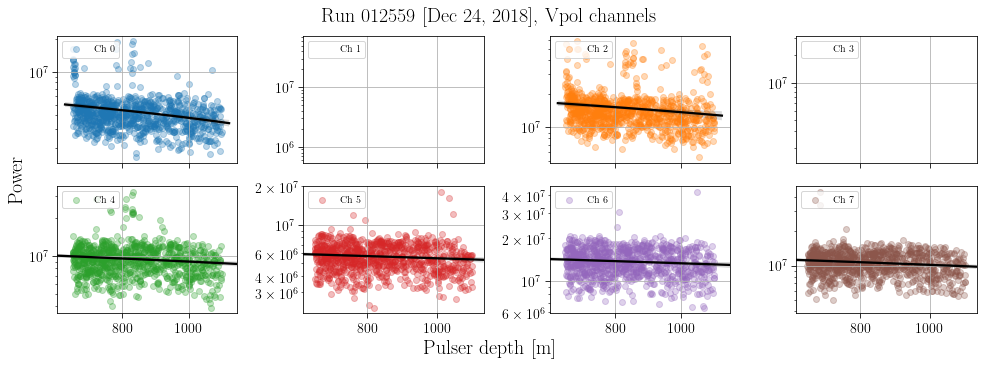

In [112]:
fig, ax = plt.subplots(2, 4, sharex='col', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[0:8], df.columns[8:]):
    if(ch==1 or ch==3):
        axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch), c = "white")
    else:
        sns.regplot(x=df.depth, y=df["%s"%a], ax = axs[ch], label = "Ch %i"%(ch), line_kws={"color": "black"}, scatter_kws={"alpha": 0.3})
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(1E6,5E7)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Vpol channels", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/PowervsDepth_run012559_scatter_Vpol.pdf', dpi=250)


No handles with labels found to put in legend.


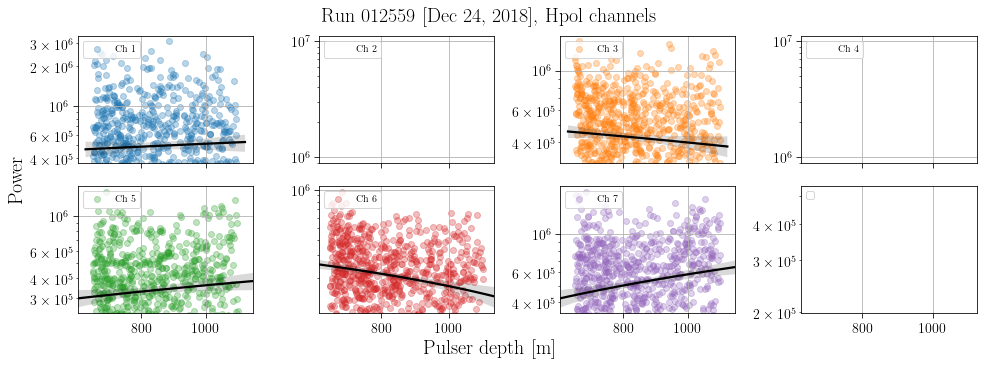

In [114]:
fig, ax = plt.subplots(2, 4, sharex='col', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
    if(ch==1 or ch==3):
        axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+1), c = "white")
    else:
        sns.regplot(x=df.depth, y=df["%s"%a], ax = axs[ch], label = "Ch %i"%(ch+1), line_kws={"color": "black"}, scatter_kws={"alpha": 0.3})
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(1E6,5E7)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Hpol channels", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/PowervsDepth_run012559_scatter_Hpol.pdf', dpi=250)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


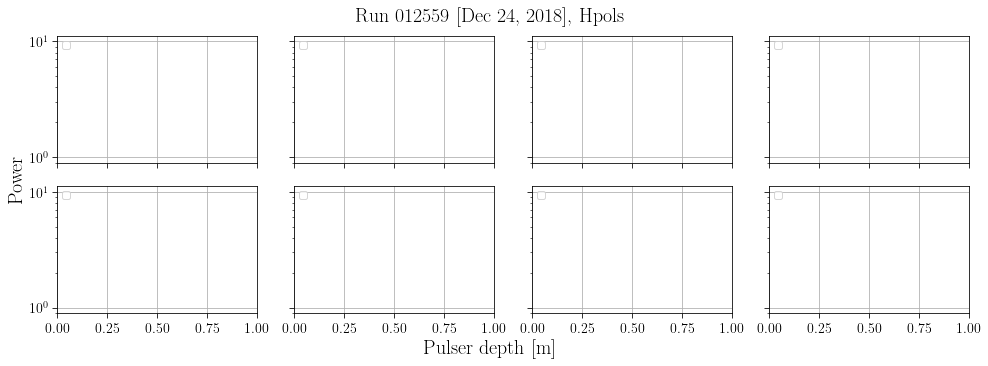

In [33]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Hpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/HpolPowervsDepthProfile_run012559.png', dpi=250)


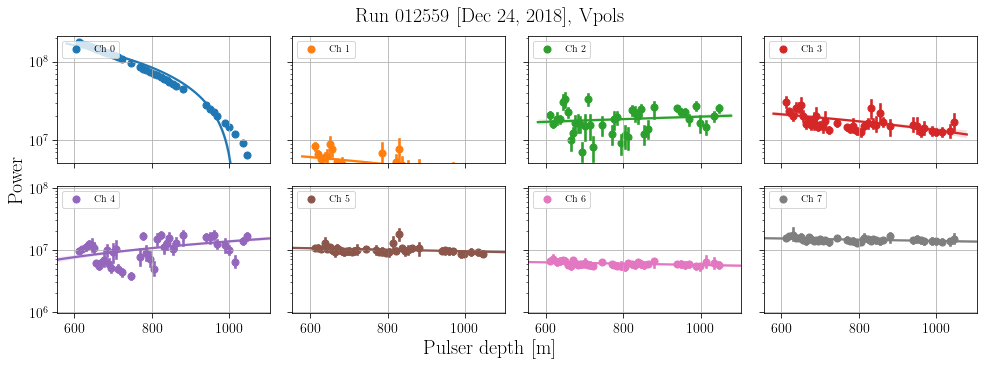

In [22]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:8], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Vpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/VpolPowervsDepthProfile_run012559.png', dpi=250)


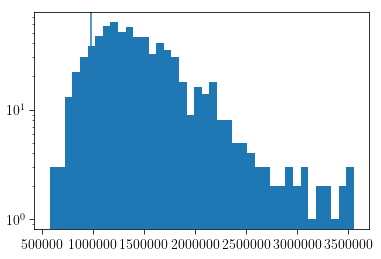

In [88]:
plt.hist(df.ch8Pow, bins = 40);
plt.axvline(noisePowerChan[8])
plt.yscale('log')

In [96]:
sub = df.ch8Pow-noisePowerChan[8]
len(sub[sub<0])/len(sub)

0.12717536813922356

In [128]:
ch = 0
chs = []
frac = []
for a,b in zip(df.columns[:16], df.columns[:16]):
    sub = df["%s"%a]-noisePowerChan[ch]
    frac.append(len(sub[sub<0])/len(sub))
    chs.append(ch)
    ch+=1

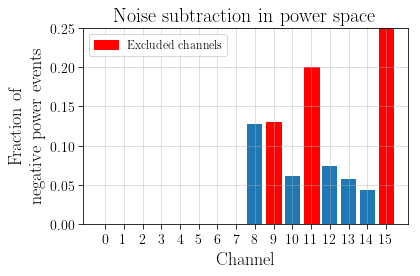

In [129]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4))
barlist = plt.bar(chs,frac)
barlist[9].set_color('r')
barlist[11].set_color('r')
barlist[15].set_color('r')

plt.xticks(np.arange(0, 16, step=1));
plt.grid(alpha = 0.5)
plt.xlabel("Channel")
plt.ylabel("Fraction of \n negative power events")
plt.title("Noise subtraction in power space")
plt.ylim(0,0.25)


red_patch = mpatches.Patch(color='red', label='Excluded channels')
plt.legend(handles=[red_patch])
plt.tight_layout()


In [140]:
def getPsi(R):
#     theta = np.radians(theta)
#     phi = np.radians(phi)
#     numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
#     denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    return np.degrees(np.arctan(R))

def getOmega(theta, R):
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = np.sqrt(1+R**2)
    return np.degrees(np.arccos(numerator/denominator))

def getR(powH, powH_noise, powV, powV_noise, chi):
    Rmeas = np.sqrt((powH-powH_noise)/(powV-powV_noise))
    return np.sqrt((1-chi)*Rmeas**2-chi)

In [142]:
def find68Perc(x,y):
    for bins in range(len(y)):
        integral = sum(y[:bins])*(x[1]-x[0])
        if(integral>0.68):
            break
    return x[bins]

No handles with labels found to put in legend.


2.844034863617114
[1.59053338]
2.879701756596688
[2.03926583]
2.6690174983794908
[2.66041432]
2.364544076487345
[0.00747964]
2.103524509711802
[1.22031703]
2.71172676773154
[1.38068892]
2.7334612237511693
[3.08856406]


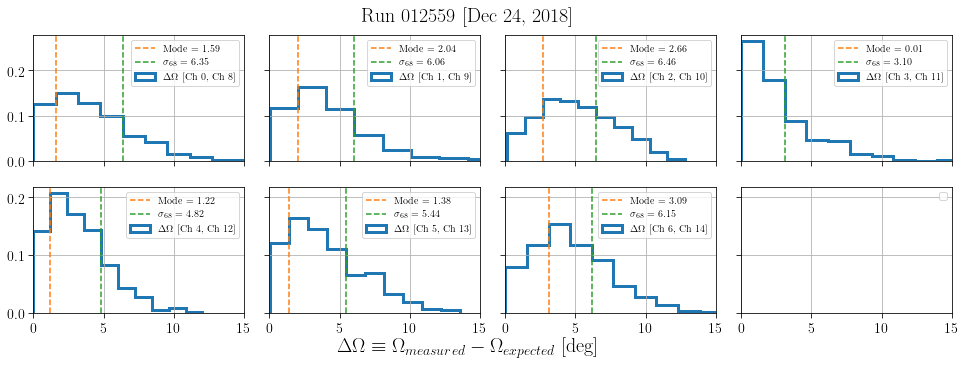

In [143]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],1,df["%s"%a]/noisePowerChan[ch],1,0.)
    values = getOmega(df.rec_ang, R)
    pol = getOmega(df.rec_ang,0)
    delta = values[~np.isnan(values)]-pol[~np.isnan(values)]
    y, x, _ = axs[ch].hist(delta,label = "$\Delta\Omega$ [Ch %i, Ch %i]"%(ch,ch+8), bins = 10, histtype='step', stacked=True, fill=False, lw = 3, density = True);
    mode = x[np.where(y == y.max())]
    axs[ch].axvline(mode, ls="--", color = "C1", label = "Mode = %0.2f"%mode)
    Interval68Pct = find68Perc(x,y)
    axs[ch].axvline(Interval68Pct, ls="--", color = "C2", label = "$\sigma_{68}$ = %0.2f"%Interval68Pct)

    ch+=1
    print(delta.std())
    print(x[np.where(y == y.max())])
for ax in axs:
    ax.set_xlim(0,15)
#     ax.set_ylim(0,30)
    ax.set(xlabel="", ylabel = "")
    ax.grid()

    ax.legend(loc="upper right", fontsize=10)

fig.text(0.5, 0.03, '$\Delta\Omega \equiv \Omega_{measured}-\Omega_{expected}$ [deg]', ha='center', va='center', fontsize=20) 
# fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmega_Amymethod_run012559.png', dpi=250)
